# Amazon Reviews Sentiment Modeling 


<b>Author:</b> Przemyslaw Niedziela (przemyslaw.niedziela98@gmail.com) <br> 
<b>Date:</b> Nov 2024 <br>
<br> <br> 

TL;DR <br>
WIP

<br> <br> 
Table of contents: 

In [53]:
import re
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import pipeline

warnings.filterwarnings('ignore')

In [2]:
DATASET_PATH = "/Users/przemyslawniedziela/.cache/kagglehub/datasets/arhamrumi/amazon-product-reviews/versions/1/Reviews.csv"

CONTRACTIONS = {
    "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
    "'t": " not", "'ve": " have", "'m": " am"
}

### Preprocessing 

Expanding contractions, removing stopwords, lammatization and tokenization.

In [3]:
dataset = pd.read_csv(DATASET_PATH, index_col = [0])
dataset_subset = dataset.sample(int(1e5))

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
def expand_contractions(text):
    """Expand common contractions in text."""
    for contraction, expanded in CONTRACTIONS.items():
        text = re.sub(contraction, expanded, text)
    return text

def preprocess_text(text):
    """
    Preprocess the input text by cleaning, normalizing, and tokenizing.

    - Convert text to lowercase.
    - Expand contractions.
    - Remove punctuation and special characters.
    - Remove numbers.
    - Remove stopwords.
    - Lemmatize the tokens to their base forms.
    """
    text = expand_contractions(text.lower())
    text = re.sub(r'[^a-z\s]', '', text) 
    tokens = word_tokenize(text)  
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]    
    return ' '.join(tokens)

text_data = dataset_subset['Text'].apply(preprocess_text)
tokenizer = Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=100)

### Using pre-trained model for labels  

In [9]:
def generate_sentiment_labels_pretrained(text_data):
    """
    Generates sentiment labels for a list of text data using a pre-trained sentiment analysis model.
    """

    sentiment_analyzer = pipeline("sentiment-analysis", 
                                model="distilbert-base-uncased-finetuned-sst-2-english")

    sentiment_labels = []
    for text in text_data:
        result = sentiment_analyzer(text[:512])
        sentiment = result[0]['label']
        sentiment_labels.append(1 if sentiment == "POSITIVE" else 0)

    return np.array(sentiment_labels)

pseudo_labels = generate_sentiment_labels_pretrained(text_data)


In [17]:
def analyze_correlation_and_find_threshold(dataset_subset, pseudo_labels):
    """
    Analyzes the correlation between sentiment labels and scores and determines the optimal threshold 
    for binarizing the scores.
    """
    scores = dataset_subset['Score'].values
    correlation_pearson = np.corrcoef(scores, pseudo_labels)[0, 1]
    correlation_spearman = pd.Series(scores).corr(pd.Series(pseudo_labels), method='spearman')
    
    best_f1, best_threshold = 0, None
    thresholds = np.arange(1, 11) 

    for threshold in thresholds:
        binary_labels = (scores >= threshold).astype(int)
        current_f1 = f1_score(binary_labels, pseudo_labels)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    
    return {
        'pearson_correlation': correlation_pearson,
        'spearman_correlation': correlation_spearman,
        'best_threshold': best_threshold,
        'best_f1_score': best_f1
    }


results = analyze_correlation_and_find_threshold(dataset_subset, pseudo_labels)
print(f"Pearson Correlation: {results['pearson_correlation']}")
print(f"Spearman Correlation: {results['spearman_correlation']}")
print(f"Best Threshold: {results['best_threshold']} (F1-Score: {results['best_f1_score']})")


Pearson Correlation: 0.3671714006983607
Spearman Correlation: 0.3495047063603504
Best Threshold: 4 (F1-Score: 0.7146878178392059)


In [18]:
labels = (dataset_subset['Score'] >= 4).astype(int).values

In [47]:
def create_model(vocab_size, max_seq_len):
    inputs = Input(shape=(max_seq_len,))
    x = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len)(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x) 

    return Model(inputs=inputs, outputs=outputs)


model = create_model(min(len(word_index) + 1, 20000), 100)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
labels_train = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels_train, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 106s 53ms/step - accuracy: 0.9976 - loss: 0.0068 - val_accuracy: 0.9980 - val_loss: 0.0063
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9559s 5s/step - accuracy: 0.9982 - loss: 0.0054 - val_accuracy: 0.9963 - val_loss: 0.0113
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 106s 53ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9936 - val_loss: 0.0165
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 102s 51ms/step - accuracy: 0.9980 - loss: 0.0063 - val_accuracy: 0.9949 - val_loss: 0.0184
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 111s 56ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9921 - val_loss: 0.0252
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 113s 57ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.9908 - val_loss: 0.0295
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 108s 54ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.9879 - val_loss: 0.0413
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 100s 50ms/step - accuracy: 0

In [55]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8740 - loss: 1.5817
Test Loss: 1.5392
Test Accuracy: 0.8744


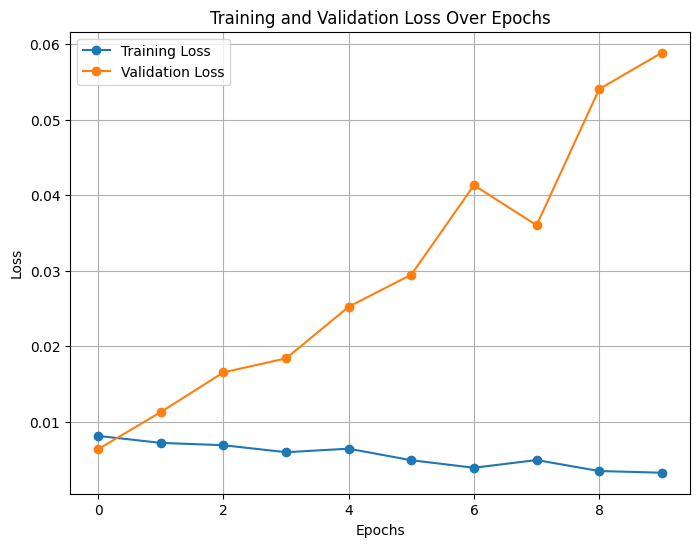

In [54]:
training_loss = history.history['loss']
validation_loss = history.history.get('val_loss')

plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss', marker='o')
if validation_loss is not None:
    plt.plot(validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
new_texts = dataset.sample(10)
text_data = new_texts['Text'].apply(preprocess_text)
new_sequences = tokenizer.texts_to_sequences(text_data)
new_data = pad_sequences(new_sequences, maxlen=100)

predictions = model.predict(new_data)
predicted_labels = (predictions > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
